# Timeseries IV Simulation

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from pvops.iv import timeseries_simulator
from pvops.timeseries import preprocess
from pvops.timeseries.models import linear
from pvops.text2time import utils as t2t_utils, preprocess as t2t_preprocess

Next we load in example data. We only simulate for irradiance above 200 
select one of the two sites to focus on. Additionally, we drop rows without
the data needed for simulation.

In [91]:
example_prodpath = os.path.join('example_data', 'example_prod_with_covariates.csv')
env_df = pd.read_csv(example_prodpath)
env_df.index = pd.to_datetime(env_df["date"])
env_df = env_df.sort_index()

# Only simulate where irradiance > 200
env_df = env_df[env_df['irrad_poa_Wm2'] > 200]
# Two sites have data here so we choose one
env_df = env_df[env_df['randid'] == 'R15']
# Remove any NaN environmental specifications
env_df = env_df.dropna(subset=['irrad_poa_Wm2','temp_amb_C'])
env_df.head()

,date,randid,generated_kW,expected_kW,irrad_poa_Wm2,temp_amb_C,wind_speed_ms,temp_mod_C
date,,,,,,,,
2018-04-01 09:00:00,2018-04-01 09:00:00,R15,6616.573,7343.981135,367.9035,20.1680,4.5095,24.5745
2018-04-01 10:00:00,2018-04-01 10:00:00,R15,8847.800,10429.876422,508.2870,21.9870,4.9785,30.7740
2018-04-01 11:00:00,2018-04-01 11:00:00,R15,11607.389,12981.228814,618.7945,23.4170,4.6410,35.8695
2018-04-01 12:00:00,2018-04-01 12:00:00,R15,15860.138,20000.000000,992.8930,24.3280,4.3235,44.8640
2018-04-01 13:00:00,2018-04-01 13:00:00,R15,15672.136,18737.585012,861.8760,25.1885,5.1810,44.3385


In [92]:
metadata = pd.DataFrame()
metadata['randid'] = ['R15', 'R10']
metadata.head()

,randid
0,R15
1,R10


In [93]:
#Format for dictionaries is {pvops variable: user-specific column names}
prod_col_dict = {
    'siteid': 'randid', 
    'timestamp': 'date', 
    'powerprod': 'generated_kW',
    'irradiance':'irrad_poa_Wm2',
    'temperature':'temp_amb_C', # Optional parameter, used by one of the modeling structures
    'baseline': 'IEC_pstep', #user's name choice for new column (baseline expected energy defined by user or calculated based on IEC)
    'dcsize': 'dcsize', #user's name choice for new column (System DC-size, extracted from meta-data)
    'compared': 'Compared', #user's name choice for new column
    'energy_pstep': 'Energy_pstep' #user's name choice for new column
    }

metad_col_dict = {'siteid': 'randid'}

In [94]:
failureA = timeseries_simulator.TimeseriesFailure()
longterm_fcn_dict = {
    'Rs_mult': "degrade"
}
annual_fcn_dict = {
    'Rs_mult': lambda x : ( 0.3 * np.sin(np.pi * x) )
}

failureA.trend(longterm_fcn_dict=longterm_fcn_dict,
               annual_fcn_dict=annual_fcn_dict,
               degradation_rate=1.005)

iv_col_dict = {'irradiance': 'irrad_poa_Wm2',
               'temperature': 'temp_amb_C'
               }

env_df['identifier'] = env_df.index.strftime("%Y-%m-%d %H:%M:%S")

time_simulator = timeseries_simulator.IVTimeseriesGenerator()
condition_dicts = time_simulator.generate(env_df, [failureA], iv_col_dict, 'identifier', plot_trends=False)

Text(0, 0.5, 'Rs_mult')

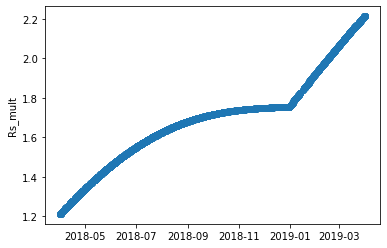

In [95]:
plt.scatter(time_simulator.specs_df.index, time_simulator.specs_df['Rs_mult'])
plt.ylabel('Rs_mult')

In [96]:
time_simulator.add_time_conditions('complete', nmods=12)
time_simulator.simulate()

Simulating cells:   0%|          | 0/3307 [00:00<?, ?it/s]/home/klbonne/.local/bin/anaconda3/envs/pvops_dev/lib/python3.8/site-packages/scipy/optimize/_zeros_py.py:466: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 3307/3307 [00:00<00:00, 29882.31it/s]


In [97]:
sims_df = time_simulator.sims_to_df(focus=['string'], cutoff=True)

In [98]:
sims_df.head()

,current,voltage,E,T,mode,level
0,"[3.3373719452150903, 3.3359903398092783, 3.334...","[3.836930773104541e-12, 11.97867132786855, 23....",367.9035,20.1680,str_2018-04-01 09:00:00,string
1,"[4.614599256674858, 4.612678148222023, 4.61080...","[3.836930773104541e-12, 12.058127583686556, 23...",508.2870,21.9870,str_2018-04-01 10:00:00,string
2,"[5.621465807867254, 5.6191204837065545, 5.6168...","[3.8331560148208155e-12, 12.093588347866122, 2...",618.7945,23.4170,str_2018-04-01 11:00:00,string
3,"[9.020136734061941, 9.016314598640065, 9.01258...","[3.836930773104541e-12, 12.288852807799348, 24...",992.8930,24.3280,str_2018-04-01 12:00:00,string
4,"[7.834888228861011, 7.831598650286882, 7.82838...","[3.836930773104541e-12, 12.182321719206548, 24...",861.8760,25.1885,str_2018-04-01 13:00:00,string


In [99]:
pmaxs = np.array([max(np.array(row['current']) * np.array(row['voltage']))
            for ind,row in sims_df.iterrows()])

env_df["simulated_power"] = pmaxs

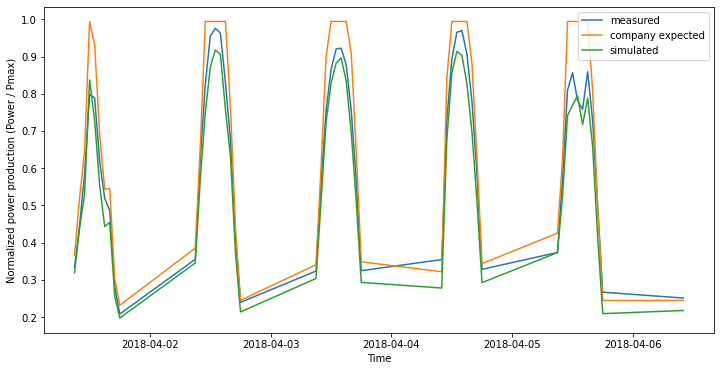

In [100]:
def plot(input_df, npts_viz=50):
    df = input_df.copy()
    df['generated_kW'] = df['generated_kW'] / df['generated_kW'].max()
    df['expected_kW'] = df['expected_kW'] / df['expected_kW'].max()
    df['simulated_power'] = df['simulated_power'] / df['simulated_power'].max()

    plt.figure(figsize=(12,6))
    plt.plot(df.index[0:npts_viz], df['generated_kW'].iloc[0:npts_viz], label='measured')
    plt.plot(df.index[0:npts_viz], df['expected_kW'].iloc[0:npts_viz], label='company expected')
    plt.plot(df.index[0:npts_viz], df['simulated_power'].iloc[0:npts_viz], label='simulated')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Normalized power production (Power / Pmax)")
    plt.show()

plot(env_df)

## Timeseries simulations

Using the environmental conditions and the physics-based estimation as input, we inference an output.

In [101]:
prod_data_converted = t2t_preprocess.prod_date_convert(env_df, prod_col_dict)
prod_data_datena_d, _ = t2t_preprocess.prod_nadate_process(prod_data_converted, prod_col_dict, pnadrop=True)
prod_data_datena_d.index = prod_data_datena_d[prod_col_dict['timestamp']]

In [102]:
masked_prod_data = preprocess.prod_inverter_clipping_filter(prod_data_datena_d, prod_col_dict, metadata, metad_col_dict, 'threshold', freq=60)

filtered_prod_data = masked_prod_data.loc[masked_prod_data['mask'] == False,:]

/home/klbonne/Documents/GitHub/pvOps/pvops/timeseries/preprocess.py:322: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  prod_df.loc[site_prod_mask, "mask"] = pvanalytics.features.clipping.threshold(


In [103]:
model_prod_data = filtered_prod_data.dropna(subset=['irrad_poa_Wm2', 'temp_amb_C', 'wind_speed_ms']+[prod_col_dict['powerprod']])

In [104]:
from sklearn.metrics import mean_squared_error, r2_score

def plot_inference(model, prod_col_dict, data_split='test', npts=50):

    def print_info(real,pred,name):
        mse = mean_squared_error(real, pred)
        r2 = r2_score(real, pred)
        print(f'[{name}] Mean squared error: %.2f'
                % mse)
        print(f'[{name}] Coefficient of determination: %.2f'
                % r2)

    fig,(ax) = plt.subplots(figsize=(14,8))

    if data_split == 'test':
        df = test_df
    elif data_split == 'train':
        df = train_df

    measured = model.estimators['OLS'][f'{data_split}_y'][:npts]

    ax2 = ax.twinx()
    ax2.plot(model.estimators['OLS'][f'{data_split}_index'][:npts], df[prod_col_dict['irradiance']].values[:npts], 'k', label='irradiance')

    ax.plot(model.estimators['OLS'][f'{data_split}_index'][:npts], df['expected_kW'].values[:npts], label='partner_expected')
    print_info(measured, df['expected_kW'].values[:npts], 'partner_expected')

    ax.plot(model.estimators['OLS'][f'{data_split}_index'][:npts], measured, label='measured')
    for name, info in model.estimators.items():
        predicted = model.estimators[name][f'{data_split}_prediction'][:npts]
        ax.plot(model.estimators[name][f'{data_split}_index'][:npts], predicted, label=name)
        print_info(measured, predicted, name)

    ax2.set_ylabel("Irradiance (W/m2)")
    ax.set_ylabel("Power (W)")
    ax.set_xlabel('Time')
    handles, labels = [(a+b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
    ax.legend(handles, labels, loc='best')
    plt.show()

## Power modeling using environmental conditions

In [105]:
# Make sure to only pass data for one site! If sites are very similar, you can consider providing both sites.
model, train_df, test_df = linear.modeller(
                                            prod_col_dict,
                                            kernel_type='default',
                                            time_weighted='month',
                                            X_parameters=['irrad_poa_Wm2', 'temp_amb_C'],
                                            Y_parameter='generated_kW',
                                            prod_df=model_prod_data,
                                            test_split=0.05,
                                            degree=3,
                                            verbose=1)

train {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
test {3}

Begin training.
[OLS] Mean squared error: 933524.95
[OLS] Coefficient of determination: 0.96
[OLS] 24 coefficient trained.
[RANSAC] Mean squared error: 1052555.85
[RANSAC] Coefficient of determination: 0.95

Begin testing.
[OLS] Mean squared error: 510178.49
[OLS] Coefficient of determination: 0.98
[OLS] 24 coefficient trained.
[RANSAC] Mean squared error: 1743431.22
[RANSAC] Coefficient of determination: 0.93


/home/klbonne/.local/bin/anaconda3/envs/pvops_dev/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


[partner_expected] Mean squared error: 3433925.51
[partner_expected] Coefficient of determination: 0.85
[OLS] Mean squared error: 270424.03
[OLS] Coefficient of determination: 0.99
[RANSAC] Mean squared error: 268835.82
[RANSAC] Coefficient of determination: 0.99


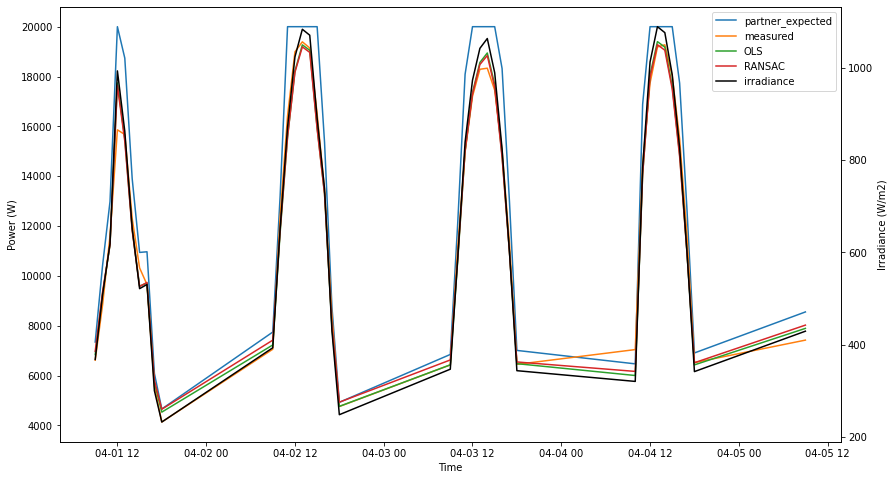

In [106]:
plot_inference(model, prod_col_dict, data_split='train', npts=40)

[partner_expected] Mean squared error: 180731.98
[partner_expected] Coefficient of determination: 0.99
[OLS] Mean squared error: 275562.47
[OLS] Coefficient of determination: 0.99
[RANSAC] Mean squared error: 2293599.51
[RANSAC] Coefficient of determination: 0.90


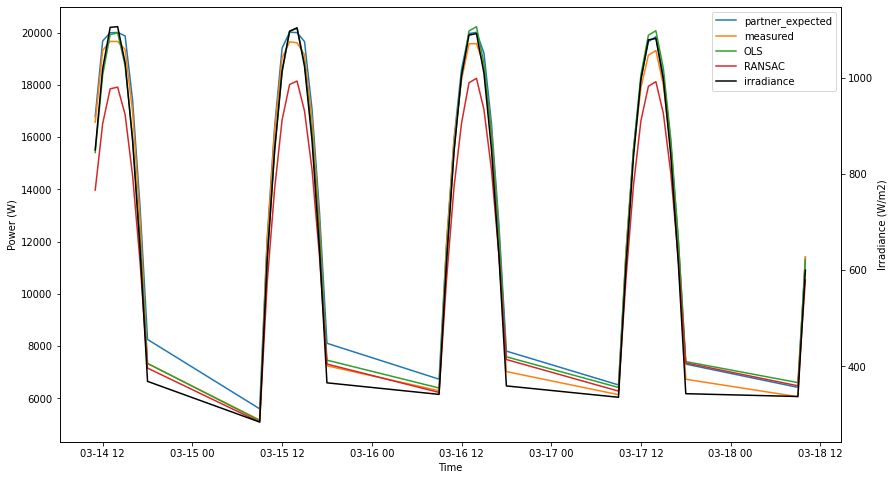

In [107]:
plot_inference(model, prod_col_dict, data_split='test', npts=40)

## Power modeling using physics simulations as input

In [108]:
# Make sure to only pass data for one site! If sites are very similar, you can consider providing both sites.
model, train_df, test_df = linear.modeller(
                                            prod_col_dict,
                                            kernel_type='default',
                                            time_weighted='month',
                                            X_parameters=['irrad_poa_Wm2', 'temp_amb_C', 'simulated_power'],
                                            Y_parameter='generated_kW',
                                            prod_df=model_prod_data,
                                            test_split=0.05,
                                            degree=3,
                                            verbose=1)

train {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
test {3}

Begin training.
[OLS] Mean squared error: 754429.15
[OLS] Coefficient of determination: 0.97
[OLS] 36 coefficient trained.
[RANSAC] Mean squared error: 788074.79
[RANSAC] Coefficient of determination: 0.97

Begin testing.
[OLS] Mean squared error: 482864.39
[OLS] Coefficient of determination: 0.98
[OLS] 36 coefficient trained.
[RANSAC] Mean squared error: 1005442.42
[RANSAC] Coefficient of determination: 0.96


[partner_expected] Mean squared error: 3433925.51
[partner_expected] Coefficient of determination: 0.85
[OLS] Mean squared error: 241325.46
[OLS] Coefficient of determination: 0.99
[RANSAC] Mean squared error: 232528.26
[RANSAC] Coefficient of determination: 0.99


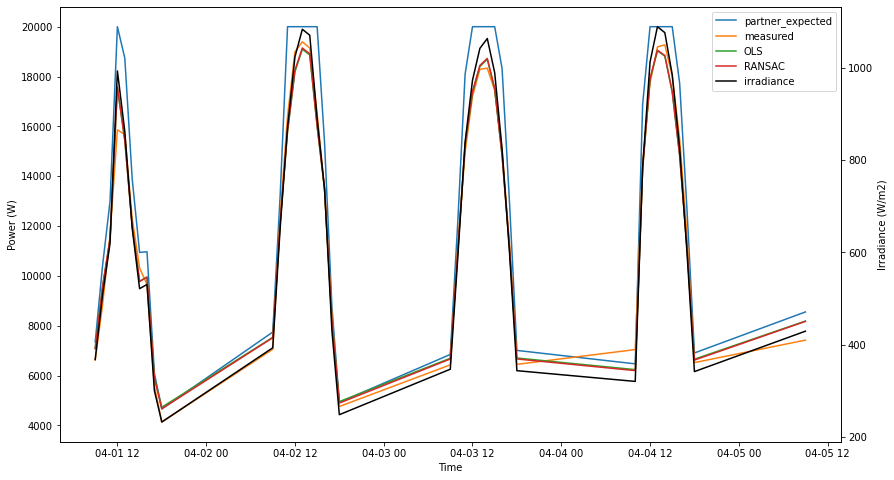

In [109]:
plot_inference(model, prod_col_dict, data_split='train', npts=40)

[partner_expected] Mean squared error: 180731.98
[partner_expected] Coefficient of determination: 0.99
[OLS] Mean squared error: 355754.91
[OLS] Coefficient of determination: 0.98
[RANSAC] Mean squared error: 566091.79
[RANSAC] Coefficient of determination: 0.98


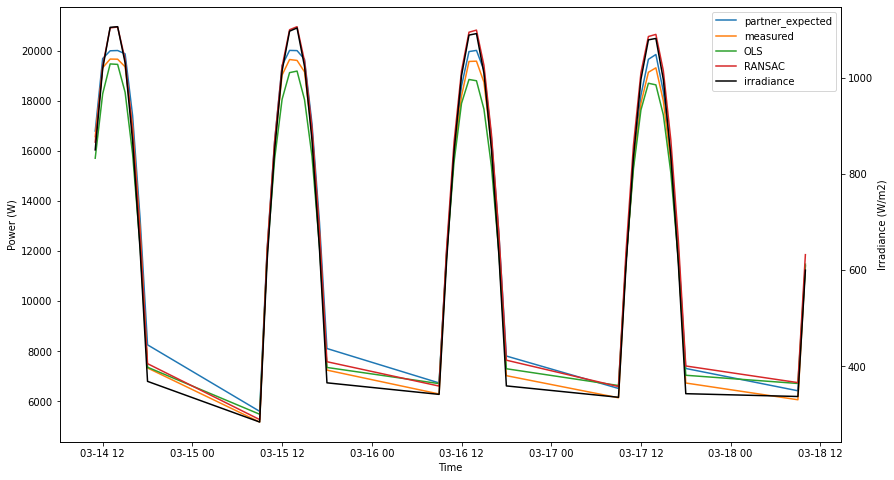

In [110]:
plot_inference(model, prod_col_dict, data_split='test', npts=40)